In [135]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Not enough people know this exists
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr
from scipy.stats import norm
# Import ML
from xgboost import XGBRegressor
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV, LarsCV, OrthogonalMatchingPursuitCV, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.svm import LinearSVR,SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
LabelEnc = preprocessing.LabelEncoder()
OHE = preprocessing.OneHotEncoder()

In [2]:
train_data = pd.read_csv(r'E:/Downloads/Housing/train.csv')
test_data = pd.read_csv(r'E:/Downloads/Housing/test.csv')

In [113]:
def outlier_and_nans(train):
    """ Remove outliers and nans from training data"""
    train = train.drop(index=train.GrLivArea.nlargest(2).index)
    train = train.drop(index=train.SalePrice.nlargest(1).index)
    train = train.dropna(subset=['MasVnrArea'])  # Around 8 examples
    train = train.drop(index=train.GarageArea.nlargest(3).index)
    return train

In [4]:
def fill_nans(test):
    test['MasVnrArea'].fillna(test['MasVnrArea'].mean(), inplace=True)
    test['GarageArea'].fillna(test['GarageArea'].mean(), inplace=True)
    test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean(), inplace=True)

In [5]:
def feature_extraction(data, dummies):
    X = pd.DataFrame(index=data.index)
    X['OverallQual'] = preprocessing.scale(data['OverallQual'])  # Maybe scale it later
    X['GrLivArea'] = preprocessing.scale(np.log(data['GrLivArea']))
    X['GarageArea'] = preprocessing.scale(data['GarageArea'].apply(lambda x: x if x == 0 else np.log(x)))
    X['TotalBsmtSF'] = preprocessing.scale(data['TotalBsmtSF'].apply(lambda x: x if x == 0 else np.log(x)))
    X['FullBaths'] = preprocessing.scale(data['FullBath'])  # Maybe scale it later
    X['AgeWhenSold'] = preprocessing.scale(data['YrSold'] - data['YearBuilt'])
    X['MasVnrArea'] = preprocessing.scale(data['MasVnrArea'].apply(lambda x: x if x == 0 else np.log(x)))
    data['HasFirePlace'] = 0
    data.loc[data['Fireplaces'] != 0,'HasFirePlace'] = 1
    X['HasFirePlace'] = data['HasFirePlace']
    X = pd.concat([X,pd.get_dummies(data[dummies])], axis=1)
    return X

In [134]:
def prepare_for_model(train, test, tag):
    dummies = train.dtypes[train.dtypes == object].index
    X_train = feature_extraction(train, dummies)
    y_train = np.log(tag)
    X_test = feature_extraction(test, dummies)
    X_train = X_train[X_test.columns]
    X_test = X_test[X_train.columns]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size= 0.2)
    return X_train, y_train, X_val, y_val, X_test
    
    

In [179]:
def fit_predict(train, test, model):
    X_train, y_train, X_val, y_val, X_test = prepare_for_model(train, test, train["SalePrice"])
    clf = LassoCV()
    sfm = SelectFromModel(clf, threshold=None)
    sfm.fit(X_train, y_train)
    print(X_train.shape)
    X_train = sfm.transform(X_train)
    X_val = sfm.transform(X_val)
    X_test = sfm.transform(X_test)
    print(X_train.shape)
    model.fit(X_train, y_train)
    print("Train error: ",np.sqrt(mean_squared_log_error(np.exp(y_train),np.exp(model.predict(X_train)))))
    print("Val error: ", np.sqrt(mean_squared_log_error(np.exp(y_val), np.exp(model.predict(X_val)))))
    pred = np.exp(pd.Series(model.predict(X_test)))
    pred.name = "SalePrice"
    return model, pd.concat([test.Id,pred],axis = 1)

In [115]:
print(train_data.shape)
train_r = outlier_and_nans(train_data)
print(train_r.shape)

(1460, 81)
(1446, 81)


In [12]:
fill_nans(test_data)

Id                True
MSSubClass        True
MSZoning         False
LotFrontage      False
LotArea           True
Street            True
Alley            False
LotShape          True
LandContour       True
Utilities        False
LotConfig         True
LandSlope         True
Neighborhood      True
Condition1        True
Condition2        True
BldgType          True
HouseStyle        True
OverallQual       True
OverallCond       True
YearBuilt         True
YearRemodAdd      True
RoofStyle         True
RoofMatl          True
Exterior1st      False
Exterior2nd      False
MasVnrType       False
MasVnrArea        True
ExterQual         True
ExterCond         True
Foundation        True
                 ...  
BedroomAbvGr      True
KitchenAbvGr      True
KitchenQual      False
TotRmsAbvGrd      True
Functional       False
Fireplaces        True
FireplaceQu      False
GarageType       False
GarageYrBlt      False
GarageFinish     False
GarageCars       False
GarageArea        True
GarageQual 

In [187]:
model = XGBRegressor()
model_out, out = fit_predict(train_r ,test_data ,model)
# out.to_csv(r'out.csv',index=False)
model_out.feature_importances_

c:\users\noam\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


(1156, 242)
(1156, 107)
[13:37:15] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\noam\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train error:  0.09694422345826695
Val error:  0.12482494234830396


array([0.06596678, 0.04621912, 0.05116463, 0.0401483 , 0.00615022,
       0.04589282, 0.00320501, 0.10363725, 0.0105974 , 0.00245024,
       0.03046652, 0.01934053, 0.00100326, 0.00296475, 0.01570544,
       0.        , 0.0058313 , 0.00144469, 0.00301083, 0.0059507 ,
       0.00239931, 0.00853954, 0.00426863, 0.00316815, 0.        ,
       0.        , 0.        , 0.0113389 , 0.        , 0.        ,
       0.00307487, 0.        , 0.00417096, 0.00282684, 0.00413714,
       0.        , 0.01139193, 0.        , 0.00016679, 0.00358291,
       0.00229227, 0.00375165, 0.00106623, 0.        , 0.        ,
       0.00548465, 0.        , 0.00555285, 0.        , 0.00203011,
       0.0017671 , 0.00151966, 0.        , 0.00327561, 0.00122846,
       0.        , 0.00325109, 0.01160382, 0.        , 0.        ,
       0.00841336, 0.        , 0.        , 0.00424213, 0.01541492,
       0.        , 0.00432195, 0.        , 0.01430262, 0.00067784,
       0.00662732, 0.00579173, 0.04525412, 0.        , 0.00093

In [146]:
SelectFromModel(model_out).fit()

TypeError: fit() missing 1 required positional argument: 'X'

In [45]:
k = SelectKBest(chi2, k=100).fit(f, train_r['SalePrice'])
r = f.iloc[:,k.get_support(indices=True)].columns

NameError: name 'f' is not defined

In [42]:
for i in [2.5,3,3.5]:
    print(i)
    fit_predict(train_r, test_data, Ridge(alpha=i))

2.5
Train error:  0.10597404986833515
Val error:  0.11094186065552247
3
Train error:  0.10504164728576822
Val error:  0.11725435799410161
3.5
Train error:  0.10160362825949235
Val error:  0.13149421226599114


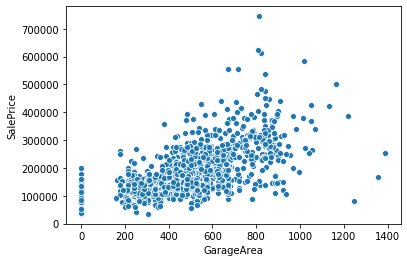

In [112]:
sns.scatterplot(x=train_r['GarageArea'], y=train_r['SalePrice'])